In [1]:
# 필요한 기본 패키지 준비

# 데이터 처리 필요 패키지
import numpy as np
import pandas as pd
import datetime as dt

# 시각화 필요 패키지
%matplotlib inline
from plotnine import *
import folium
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc, font_manager
import seaborn as sns


# Machine Learning 분석 환경 준비

# 전처리, 스케일링
from sklearn.preprocessing import StandardScaler

# 선형회귀분석
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from scipy import stats

# OLS회귀분석
import statsmodels.api as sm

# GAM 일반화가법모형
# LinearGAM, LogisticGAM, PoissonGAM, GammaGAM, InvGuss
from pygam import LinearGAM, LogisticGAM, PoissonGAM, GammaGAM

# Boosting

#데이터셋 분리
from sklearn.model_selection import train_test_split



# 한글 처리
font_name = font_manager.FontProperties(fname='C:/Windows/Fonts/NanumGothicCoding.ttf').get_name()
rc('font',family=font_name)

# - 마이너스 사인 처리
matplotlib.rcParams['axes.unicode_minus'] = False

# jupyter notebook에서 warning 무시하기
import warnings
warnings.filterwarnings("ignore")

#########################################################################
# MAD 기반 예제코드
def mad_based_outlier(points, thresh=3.5):
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)
    modified_z_score = 0.6745 * diff / med_abs_deviation
    return modified_z_score > thresh 

# 출처: https://pythonanalysis.tistory.com/7 [Python 데이터 분석]
#########################################################################

# 소셜 데이터 처리를 위한 함수
# 1. 모든 소셜 데이터 column들의 첫번째는 : 날짜다.
# 2. 각 소셜데이터는 social_키워드.블로그/트위터/뉴스/총합 으로 되어 있다.
def changeColNames(d,before, after) : 
    # 컬럼이름 시리즈로 만들어 반환
    # 통합하기 쉽게, 모든 데이터들의 날짜컬럼 이름을 date로 통일
    new_col_names = ['date']
    new_col_names.extend(list(d.columns)[1:])
    d.columns = new_col_names
    return pd.Series(d.columns).apply(lambda x : x.replace(before,after))

#########################################################################
# modeling 함수로 만들어 처리하기
def linReg(df, item, cols_using):
    cols = cols_using
    X = df.loc[df['category']==item, cols]
    y = df.loc[df['category']==item,'qty']

    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)

    model = LinearRegression().fit(X_train, y_train)
  
    print('LinearRegression을 이용한 %s의 회귀분석 결과 :'%item)
    print('훈련세트점수 : {:.2f}'.format(model.score(X_train, y_train)))
    print('검증세트점수 : {:.2f}'.format(model.score(X_test, y_test)))

    
def ridgeReg(df, item, cols_using):
    cols = cols_using
    X = df.loc[df['category']==item,cols]
    y = df.loc[df['category']==item,'qty']

    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)

    ridge = Ridge(alpha=0.1, normalize=True, random_state=0, tol=0.001).fit(X_train, y_train)
    
    print('RidgeRegression을 이용한 %s의 회귀분석 결과 :'%item)
    print('훈련세트점수 : {:.2f}'.format(ridge.score(X_train, y_train)))
    print('검증세트점수 : {:.2f}'.format(ridge.score(X_test, y_test)))


def lassoReg(df, item, cols_using):
    cols = cols_using
    X = df.loc[df['category']==item,cols]
    y = df.loc[df['category']==item,'qty']

    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)

    lasso = Lasso(alpha=0.1, max_iter=1000).fit(X=X_train, y=y_train)
  
    print('LassoRegression을 이용한 %s의 회귀분석 결과 :'%item)
    print('훈련세트점수 : {:.2f}'.format(lasso.score(X_train, y_train)) )
    print('검증세트점수 : {:.2f}'.format(lasso.score(X_test, y_test)) )

    #사용한 특성수
    print('사용한 특성수 : {}'.format(np.sum(lasso.coef_ != 0)) )
#########################################################################

# 자료가 1일 1행이라는 전제하에
# df길이를 이용하여 날짜수를 계산, 이후 2016년 1월1일을 1번째주 1일이라 기준하에
# 몇번째 주인지 알려주는 컬럼 추가
def addDayWeek(df):
    df_work = df.copy()
    df_work['day'] = pd.Series(range(1,df_work.shape[0]+1))
    # 첫주가 1부터 시작하게 하기 위해서 +1을 했다.
    df_work['week'] = df_work['day'].apply(lambda x : x//7 +1)
    return df_work
#########################################################################
# 자료를 병합해주는 함수, 어떤 item인지 어느 컬럼을 기준으로 할지 받아서 병합
def mergeForAnalysis(df1, df2, df3, item, on_what='date'):
    merged_df = pd.merge(df1.loc[df1.category==item], df2, on=on_what, how='left')
    merged_df = pd.merge(merged_df, df3, on=on_what, how='left')
    return merged_df

# 데이터 불러오기 (전처리 된 GS, 랄라블라, 날씨)
gs = pd.read_csv('d:/project/contest/data/processed/p_gs.csv', parse_dates=['date'])
lv = pd.read_csv('d:/project/contest/data/processed/p_lavla.csv', parse_dates=['date'])
w = pd.read_csv('d:/project/contest/data/processed/p_wUVair_seoul.csv', parse_dates=['date'], index_col=0)
sns_all = pd.read_csv('d:/project/contest/data/processed/social_all.csv', parse_dates=['date'])

# GS/lv 서울시만
gs_seoul = gs.loc[gs.pvn_nm =='서울특별시']
lv_seoul = lv.loc[lv.pvn_nm =='서울특별시']
w_seoul = w.loc[w['loc']==108]

# 컬럼 이름을 변경하여 Series로 돌려주는 함수
sns_all.columns = changeColNames(sns_all,'.','_')
# ols formula입력시 오류 발생 방지를위해 컬럼명 문자열 내, 마침표(.)가 전부 underscore(_)로 변경
# sns_all.columns

cols_to_keep = ['date','bor_nm','gender','age_cd','category','qty']
lv_grouped = lv_seoul[cols_to_keep].groupby(by=['date','bor_nm','category']).sum().reset_index()
# lv_grouped.tail(2)

랄라블라
1. 선케어
2. 바디로션
3. 제모제

GS
1. 마스크
2. 맥주
3. 아이스크림

# 제모제

## 일단위 자료
#### 함수를 만들기전, 함수에 들어갈 코딩을 위한 사전 작업

In [6]:
# 서울특별시 단위로 df조정(구단위 데이터 합치기)
day_lv_grouped = lv_grouped.groupby(by=['date','category']).sum().reset_index()
# day_lv_grouped.tail(3)

# '제모제'만 골라서 날씨('w')df와 소셜('sns_all')df와 결합해 새로운 'day_gs_grouped_w_item'생성
item = '제모제'
day_lv_grouped_w_item = pd.merge(day_lv_grouped.loc[day_lv_grouped.category==item],w_seoul,on='date',how='left')
day_lv_grouped_w_sns_item = pd.merge(day_lv_grouped_w_item, sns_all,on='date',how='left')

# 날씨 - 'uv'제외. 향후 uv결측치 처리후 적용
ind_vars_w = ['temp','humid','wind','rain','snow','cloud','sun_time','lgt_time','SO2','CO','O3','NO2','PM10','PM25']
ind_vars_s = ['pm_total', 'health_total','br_total', 'hobby_total','date_total']

print('\n날씨 데이터와 %s 판매량의 상관관계'%item)
linReg(day_lv_grouped_w_sns_item,item,ind_vars_w)
ridgeReg(day_lv_grouped_w_sns_item,item,ind_vars_w)
lassoReg(day_lv_grouped_w_sns_item,item,ind_vars_w)
print('\n소셜 데이터와 %s 판매량의 상관관계'%item)
linReg(day_lv_grouped_w_sns_item,item,ind_vars_s)
ridgeReg(day_lv_grouped_w_sns_item,item,ind_vars_s)
lassoReg(day_lv_grouped_w_sns_item,item,ind_vars_s)


print('\n날씨&소셜 데이터와 %s 판매량의 상관관계'%item)
ind_vars = ['temp','humid','wind','rain','snow','cloud','sun_time','lgt_time','SO2','CO','O3','NO2','PM10','PM25'
             ,'pm_total', 'health_total','br_total', 'hobby_total','date_total']
linReg(day_lv_grouped_w_sns_item,item,ind_vars)
ridgeReg(day_lv_grouped_w_sns_item,item,ind_vars)
lassoReg(day_lv_grouped_w_sns_item,item,ind_vars)

Xy = day_lv_grouped_w_sns_item.loc[day_lv_grouped_w_sns_item['category']==item,ind_vars+['qty']]

ols_formula = "qty ~ "
w_formula = "temp + humid + wind + rain + snow + cloud + sun_time + lgt_time"
s_formula = "pm_total + health_total + br_total + hobby_total + date_total"
airPol_formula = "SO2 + CO + O3 + NO2 + PM10 + PM25"

# 모든 변수(uv제외)적용
# model = sm.OLS.from_formula(ols_formula+" + ".join([w_formula,s_formula, airPol_formula])
#     , data=Xy)


# P>|t| 0.05이하 독립변수만
model = sm.OLS.from_formula("qty ~ sun_time + pm_total + health_total + rain", data=Xy)

print(model.fit().summary())


날씨 데이터와 제모제 판매량의 상관관계
LinearRegression을 이용한 제모제의 회귀분석 결과 :
훈련세트점수 : 0.53
검증세트점수 : 0.54
RidgeRegression을 이용한 제모제의 회귀분석 결과 :
훈련세트점수 : 0.52
검증세트점수 : 0.55
LassoRegression을 이용한 제모제의 회귀분석 결과 :
훈련세트점수 : 0.53
검증세트점수 : 0.54
사용한 특성수 : 13

소셜 데이터와 제모제 판매량의 상관관계
LinearRegression을 이용한 제모제의 회귀분석 결과 :
훈련세트점수 : 0.09
검증세트점수 : 0.11
RidgeRegression을 이용한 제모제의 회귀분석 결과 :
훈련세트점수 : 0.08
검증세트점수 : 0.10
LassoRegression을 이용한 제모제의 회귀분석 결과 :
훈련세트점수 : 0.09
검증세트점수 : 0.11
사용한 특성수 : 5

날씨&소셜 데이터와 제모제 판매량의 상관관계
LinearRegression을 이용한 제모제의 회귀분석 결과 :
훈련세트점수 : 0.54
검증세트점수 : 0.55
RidgeRegression을 이용한 제모제의 회귀분석 결과 :
훈련세트점수 : 0.53
검증세트점수 : 0.55
LassoRegression을 이용한 제모제의 회귀분석 결과 :
훈련세트점수 : 0.54
검증세트점수 : 0.55
사용한 특성수 : 18
                            OLS Regression Results                            
Dep. Variable:                    qty   R-squared:                       0.532
Model:                            OLS   Adj. R-squared:                  0.531
Method:                 Least Squares   F-statistic:                     3

## 주단위 자료 생성

#### 자료생성 파트

In [7]:
cols_to_keep = ['date','bor_nm','gender','age_cd','category','qty']

# '제모제'만 골라서 날씨('w')df와 소셜('sns_all')df와 결합해 새로운 'week_gs_grouped'생성
item = '제모제'
week_lv_grouped = lv_grouped.groupby(by=['date','category']).sum().reset_index()
# week_lv_grouped.tail(2)
week_lv_grouped_gu =week_lv_grouped.loc[week_lv_grouped.category==item]
# week_lv_grouped_gu.tail(3)

# '제모제'만 골라서 날씨('w')df와 소셜('sns_all')df와 결합해 새로운 'week_gs_grouped'생성
week_lv_grouped_item = week_lv_grouped.loc[week_lv_grouped.category==item].reset_index()
# 이제 'week_lv_grouped_item'에 한 날짜에 한 item(제모제)만 들어가있는 df가 됨.

week_lv_grouped_w_item = pd.merge(week_lv_grouped,w,on='date',how='left')
week_lv_grouped_w_item_sns = pd.merge(week_lv_grouped_w_item,sns_all,on='date',how='left')
# week_lv_grouped_w_item_sns.tail(2)


week_w = addDayWeek(w_seoul)
week_w = week_w.groupby('week').mean().reset_index()
week_w.drop(columns=['loc','day','year','month','weekday','nth_week'], inplace=True)
# week_w.tail(2)

# sns자료는 2019년 4월달 자료 까지 있다.
week_sns = addDayWeek(sns_all.loc[sns_all.date.between('2016-01-01','2018-12-31', inclusive=True)])
# week_sns = week_sns.groupby('week').sum().reset_index()
week_sns = week_sns.groupby('week').mean().reset_index()
# week_sns.tail(2)

check = addDayWeek(week_lv_grouped_item)
check.drop(columns='index',inplace=True)
# check = check[['week','category','qty']].groupby(by=['week','category']).sum().reset_index()
check = check[['week','category','qty']].groupby(by=['week','category']).mean().reset_index()
# check.tail()
check_merged = mergeForAnalysis(check, week_w, week_sns, item, on_what='week')
# check_merged.columns

#### 예측모델 파트

In [10]:
ind_vars = ['temp','humid','wind','rain','snow','cloud','sun_time','lgt_time','SO2','CO','O3','NO2','PM10','PM25'
             ,'pm_total', 'health_total','br_total', 'hobby_total','date_total']
ind_vars_w = ['temp','humid','wind','rain','snow','cloud','sun_time','SO2','CO','O3','NO2','PM10','PM25']
ind_vars_s = ['pm_total', 'health_total','br_total', 'hobby_total','date_total']

print('\n날씨 데이터와 %s 판매량의 상관관계'%item)
linReg(check_merged,item,ind_vars_w)
ridgeReg(check_merged,item,ind_vars_w)
lassoReg(check_merged,item,ind_vars_w)
print('\n소셜 데이터와 %s 판매량의 상관관계'%item)
linReg(check_merged,item,ind_vars_s)
ridgeReg(check_merged,item,ind_vars_s)
lassoReg(check_merged,item,ind_vars_s)

print('\n날씨&소셜 데이터와 %s 판매량의 상관관계'%item)
linReg(check_merged,item,ind_vars)
ridgeReg(check_merged,item,ind_vars)
lassoReg(check_merged,item,ind_vars)
print('')
# ols모델
Xy = check_merged.loc[check_merged['category']==item, ind_vars+['qty']]

ols_formula = "qty ~ "
w_formula = "temp + humid + wind + rain + snow + cloud + sun_time + lgt_time"
s_formula = "pm_total + health_total + br_total + hobby_total + date_total"
airPol_formula = "SO2 + CO + O3 + NO2 + PM10 + PM25"

# 모든 변수(uv제외)적용
# model = sm.OLS.from_formula(ols_formula+" + ".join([w_formula,s_formula, airPol_formula])
#     , data=Xy)

# P>|t| 0.05이하 독립변수만
custom_formula = "qty ~ sun_time + health_total"
model = sm.OLS.from_formula(custom_formula, data=Xy)
###### temp**2로 예측율을?

print(model.fit().summary())


날씨 데이터와 제모제 판매량의 상관관계
LinearRegression을 이용한 제모제의 회귀분석 결과 :
훈련세트점수 : 0.70
검증세트점수 : 0.56
RidgeRegression을 이용한 제모제의 회귀분석 결과 :
훈련세트점수 : 0.68
검증세트점수 : 0.57
LassoRegression을 이용한 제모제의 회귀분석 결과 :
훈련세트점수 : 0.70
검증세트점수 : 0.57
사용한 특성수 : 12

소셜 데이터와 제모제 판매량의 상관관계
LinearRegression을 이용한 제모제의 회귀분석 결과 :
훈련세트점수 : 0.21
검증세트점수 : 0.21
RidgeRegression을 이용한 제모제의 회귀분석 결과 :
훈련세트점수 : 0.21
검증세트점수 : 0.20
LassoRegression을 이용한 제모제의 회귀분석 결과 :
훈련세트점수 : 0.21
검증세트점수 : 0.21
사용한 특성수 : 5

날씨&소셜 데이터와 제모제 판매량의 상관관계
LinearRegression을 이용한 제모제의 회귀분석 결과 :
훈련세트점수 : 0.73
검증세트점수 : 0.58
RidgeRegression을 이용한 제모제의 회귀분석 결과 :
훈련세트점수 : 0.71
검증세트점수 : 0.58
LassoRegression을 이용한 제모제의 회귀분석 결과 :
훈련세트점수 : 0.73
검증세트점수 : 0.59
사용한 특성수 : 17

                            OLS Regression Results                            
Dep. Variable:                    qty   R-squared:                       0.654
Model:                            OLS   Adj. R-squared:                  0.650
Method:                 Least Squares   F-statistic:                     

# uv데이터를 사용해서 예측진행
## uv 데이터 사용전 데이터 처리

In [11]:
cols_to_keep = ['date','bor_nm','gender','age_cd','category','qty']

# '제모제'만 골라서 날씨('w')df와 소셜('sns_all')df와 결합해 새로운 'week_gs_grouped'생성
item = '제모제'
week_lv_grouped = lv_grouped.groupby(by=['date','category']).sum().reset_index()
# week_lv_grouped.tail(2)
week_lv_grouped_gu =week_lv_grouped.loc[week_lv_grouped.category==item]
# week_lv_grouped_gu.tail(3)

# '제모제'만 골라서 날씨('w')df와 소셜('sns_all')df와 결합해 새로운 'week_gs_grouped'생성
week_lv_grouped_item = week_lv_grouped.loc[week_lv_grouped.category==item].reset_index()
# 이제 'week_lv_grouped_item'에 한 날짜에 한 item(제모제)만 들어가있는 df가 됨.

week_lv_grouped_w_item = pd.merge(week_lv_grouped,w,on='date',how='left')
week_lv_grouped_w_item_sns = pd.merge(week_lv_grouped_w_item,sns_all,on='date',how='left')
# week_lv_grouped_w_item_sns.tail(2)


week_w = addDayWeek(w_seoul)
week_w = week_w.groupby('week').mean().reset_index()
week_w.drop(columns=['loc','day','year','month','weekday','nth_week'], inplace=True)
# week_w.tail(2)

# sns자료는 2019년 4월달 자료 까지 있다.
week_sns = addDayWeek(sns_all.loc[sns_all.date.between('2016-01-01','2018-12-31', inclusive=True)])
# week_sns = week_sns.groupby('week').sum().reset_index()
week_sns = week_sns.groupby('week').mean().reset_index()
# week_sns.tail(2)

check = addDayWeek(week_lv_grouped_item)
check.drop(columns='index',inplace=True)
# check = check[['week','category','qty']].groupby(by=['week','category']).sum().reset_index()
check = check[['week','category','qty']].groupby(by=['week','category']).mean().reset_index()
# check.tail()
check_merged = mergeForAnalysis(check, week_w, week_sns, item, on_what='week')
# check_merged.columns

In [40]:
# uv데이터는 결측치가 많다.
print('UV 데이터 포함(결측치가 있는 주는 제거)')
check_merged = check_merged.loc[check_merged.uv.notnull()]

ind_vars = ['temp','humid','wind','rain','snow','cloud','sun_time','lgt_time','uv','SO2','CO','O3','NO2','PM10','PM25'
             ,'pm_total', 'health_total','br_total', 'hobby_total','date_total']
ind_vars_w = ['temp','humid','wind','rain','snow','cloud','sun_time','SO2','CO','O3','NO2','PM10','PM25']
ind_vars_s = ['pm_total', 'health_total','br_total', 'hobby_total','date_total']

print('\n날씨 데이터와 %s 판매량의 상관관계'%item)
linReg(check_merged,item,ind_vars_w)
ridgeReg(check_merged,item,ind_vars_w)
lassoReg(check_merged,item,ind_vars_w)
print('\n소셜 데이터와 %s 판매량의 상관관계'%item)
linReg(check_merged,item,ind_vars_s)
ridgeReg(check_merged,item,ind_vars_s)
lassoReg(check_merged,item,ind_vars_s)

print('\n날씨&소셜 데이터와 %s 판매량의 상관관계'%item)
linReg(check_merged,item,ind_vars)
ridgeReg(check_merged,item,ind_vars)
lassoReg(check_merged,item,ind_vars)
print('')
# ols모델
Xy = check_merged.loc[check_merged['category']==item, ind_vars+['qty']]

ols_formula = "qty ~ "
w_formula = "temp + humid + wind + rain + snow + cloud + sun_time + lgt_time + uv"
s_formula = "pm_total + health_total + br_total + hobby_total + date_total"
airPol_formula = "SO2 + CO + O3 + NO2 + PM10 + PM25"

# 모든 변수(uv제외)적용
# model = sm.OLS.from_formula(ols_formula+" + ".join([w_formula,s_formula, airPol_formula])
#     , data=Xy)

# 임의로 상관있다 생각되는 변수만
custom_formula = "qty ~ sun_time + PM25 + SO2"
model = sm.OLS.from_formula(custom_formula, data=Xy)
# 제모제와 '가조시간'은 이해가 가지만, 초미세먼지와 이산화황이랑??

print(model.fit().summary())

UV 데이터 포함(결측치가 있는 주는 제거)

날씨 데이터와 제모제 판매량의 상관관계
LinearRegression을 이용한 제모제의 회귀분석 결과 :
훈련세트점수 : 0.79
검증세트점수 : 0.64
RidgeRegression을 이용한 제모제의 회귀분석 결과 :
훈련세트점수 : 0.77
검증세트점수 : 0.66
LassoRegression을 이용한 제모제의 회귀분석 결과 :
훈련세트점수 : 0.75
검증세트점수 : 0.65
사용한 특성수 : 12

소셜 데이터와 제모제 판매량의 상관관계
LinearRegression을 이용한 제모제의 회귀분석 결과 :
훈련세트점수 : 0.18
검증세트점수 : 0.28
RidgeRegression을 이용한 제모제의 회귀분석 결과 :
훈련세트점수 : 0.18
검증세트점수 : 0.30
LassoRegression을 이용한 제모제의 회귀분석 결과 :
훈련세트점수 : 0.18
검증세트점수 : 0.28
사용한 특성수 : 5

날씨&소셜 데이터와 제모제 판매량의 상관관계
LinearRegression을 이용한 제모제의 회귀분석 결과 :
훈련세트점수 : 0.82
검증세트점수 : 0.57
RidgeRegression을 이용한 제모제의 회귀분석 결과 :
훈련세트점수 : 0.80
검증세트점수 : 0.60
LassoRegression을 이용한 제모제의 회귀분석 결과 :
훈련세트점수 : 0.78
검증세트점수 : 0.66
사용한 특성수 : 18

                            OLS Regression Results                            
Dep. Variable:                    qty   R-squared:                       0.733
Model:                            OLS   Adj. R-squared:                  0.725
Method:                 Least Squares   F-statis

### 임의로 Xy['qty']>3000인 값만 제거후

<function matplotlib.pyplot.show(*args, **kw)>

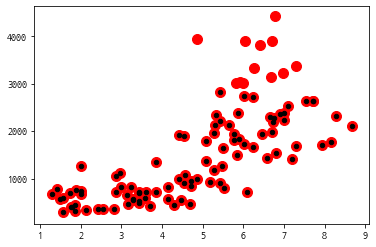

In [17]:
# uv지수 vs 판매량(주) : outlier(이상치)=red, 이상치 제거=black
plt.scatter(Xy['uv'],Xy['qty'], c='r',s=100)

Xy_no_outlier = Xy.loc[Xy.qty < 3000]
plt.scatter(Xy_no_outlier['uv'],Xy_no_outlier['qty'], c='k',s=20)
plt.show

In [19]:
# 판매량(주)이 3000 이상인 이상치 제거 후 모델
model = sm.OLS.from_formula(
    "qty ~ sun_time"
    , data=Xy_no_outlier)

# model = sm.OLS.from_formula("qty ~ temp + uv + pm_total + health_total ", data=Xy_no_outlier)

print(model.fit().summary())

                            OLS Regression Results                            
Dep. Variable:                    qty   R-squared:                       0.700
Model:                            OLS   Adj. R-squared:                  0.697
Method:                 Least Squares   F-statistic:                     212.7
Date:                Fri, 12 Jul 2019   Prob (F-statistic):           1.53e-25
Time:                        11:09:01   Log-Likelihood:                -691.36
No. Observations:                  93   AIC:                             1387.
Df Residuals:                      91   BIC:                             1392.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -3834.5696    354.092    -10.829      0.0

### MAD기법 적용

<function matplotlib.pyplot.show(*args, **kw)>

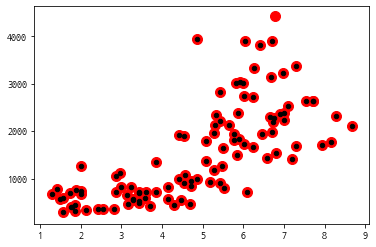

In [20]:
Xy_no_outlier = Xy.copy()
Xy_no_outlier['outlier'] = mad_based_outlier(Xy_no_outlier['qty'],thresh=2.5)
df_working = Xy_no_outlier.loc[Xy_no_outlier.outlier==False]

plt.scatter(Xy['uv'],Xy['qty'], c='r',s=100)
plt.scatter(df_working['uv'],df_working['qty'], c='k',s=20)
plt.show

In [32]:
model = sm.OLS.from_formula(
    "qty ~ I(uv**2)"
    , data=Xy_no_outlier)

# model = sm.OLS.from_formula("qty ~ sun_time", data=Xy)

ols_model = model.fit()
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:                    qty   R-squared:                       0.506
Model:                            OLS   Adj. R-squared:                  0.501
Method:                 Least Squares   F-statistic:                     104.3
Date:                Fri, 12 Jul 2019   Prob (F-statistic):           2.75e-17
Time:                        11:13:39   Log-Likelihood:                -826.42
No. Observations:                 104   AIC:                             1657.
Df Residuals:                     102   BIC:                             1662.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    482.8757    121.766      3.966      0.0

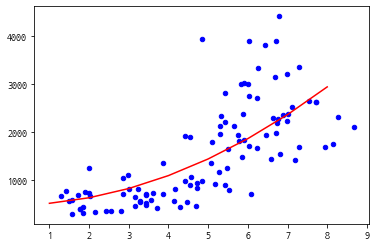

In [36]:
# 이상치제거한 자료로 산출한 모델 vs 이상치제거 하지않은 원본 데이터
intercept = 482.8757    
c1 = 38.5096      

plt.scatter(Xy['uv'],Xy['qty'], c='b',s=20)
# sun_time_list = pd.Series(list(range(int(Xy.sun_time.min()),int(Xy.sun_time.max())+1)))
# plt.plot(sun_time_list, intercept + c1*(sun_time_list), c='k')

uv_list = pd.Series(list(range(int(Xy.uv.min()),int(Xy.uv.max())+1)))
plt.plot(uv_list, intercept + c1*(uv_list ** 2), c='r')
plt.show()